---

title: Explaining and Implementing Hierarchical Clustering
date: 2022-08-24
author: Hongtao Hao
slug: hier_cluster
draft: false
toc: true
tags: ML

---

In this post, I'll explain what hierarchical clustering is and how to implement it with `Python`. 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.random.seed(1234)
N = 10 # number of points
matrix = np.random.rand(N, 2) # N points in 2 dimensional space
M = matrix * 10 # multiply ten so that the numbers are easier to understand. 
# Otherwise, all numbers are between 0 and 1
M

array([[1.9151945 , 6.22108771],
       [4.37727739, 7.85358584],
       [7.79975808, 2.72592605],
       [2.76464255, 8.01872178],
       [9.58139354, 8.75932635],
       [3.5781727 , 5.00995126],
       [6.83462935, 7.12702027],
       [3.70250755, 5.61196186],
       [5.03083165, 0.1376845 ],
       [7.72826622, 8.82641191]])

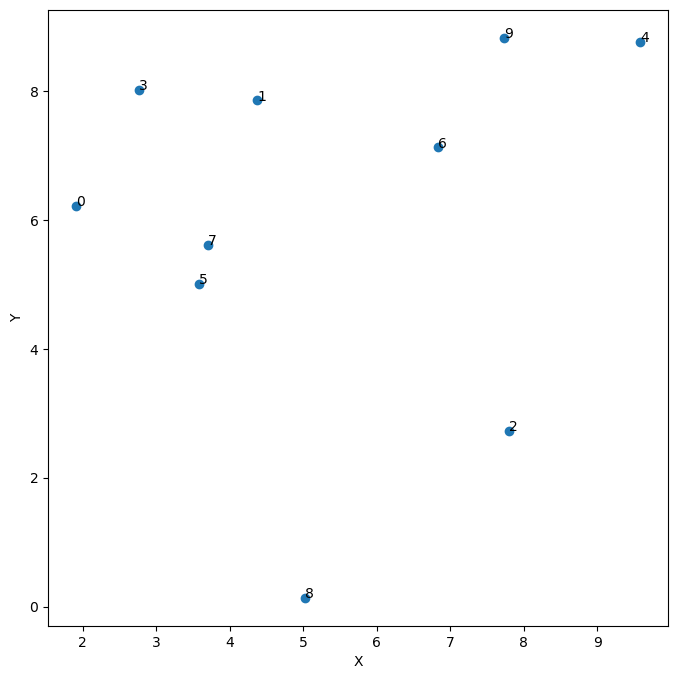

In [6]:
X = M[:, 0]
Y = M[:, 1]
from matplotlib.pyplot import figure
figure(figsize = (8,8), dpi = 100)
plt.scatter(X,Y)
plt.xlabel('X')
plt.ylabel('Y')
for i in range(N):
    plt.text(X[i], Y[i], str(i))

## 1. Euclidean distance

In [7]:
def eu_distance(x,y):
    d_square = np.sum((x-y)**2)
    d = np.sqrt(d_square)
    return d

In [8]:
eu_distance(M[1], M[3])

1.6210678581988338

## 2. Distance matrix

In [9]:
d_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i < j:
            d_matrix[i,j] = eu_distance(M[i], M[j])
        else:
            d_matrix[i,j] = 10**5

In [10]:
d_matrix_df = pd.DataFrame(d_matrix)
# display a portion for the sake of space:
d_matrix_df.iloc[0:6, 0:6]

,0,1,2,3,4,5
0,100000.0,2.954133,6.844285,1.988228,8.075473,2.057267
1,100000.0,100000.000000,6.164922,1.621068,5.282347,2.953782
2,100000.0,100000.000000,100000.000000,7.305209,6.290957,4.799849
3,100000.0,100000.000000,100000.000000,100000.000000,6.856864,3.116814
4,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,7.077886
5,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000


(array([1]), array([0]))

## 3. How does hierarchical clustering work

In our example, we have 10 data points, or nodes. The first step is to group the two nodes whose distance is the smallest among all distances. 

In [204]:
all_ds = np.unique(d_matrix) # all unique distances
len(all_ds)

46

In [205]:
for i in range(len(all_ds)):
    print(np.where(d_matrix == np.sort(all_ds)[i]))
# the returned result of np.where(array == number) will be 
# a tuple of two arrays. The first array in the tuple is the indice of row
# the second array is the indice of column
# array[row_idx, col_idx] == number 

# If still unclear:
# a_matrix = np.array([[1,2], [3, 4], [5, 6]])
# np.where(a_matrix == 3)

(array([5]), array([7]))
(array([1]), array([3]))
(array([4]), array([9]))
(array([0]), array([7]))
(array([6]), array([9]))
(array([0]), array([3]))
(array([0]), array([5]))
(array([1]), array([7]))
(array([1]), array([6]))
(array([3]), array([7]))
(array([1]), array([5]))
(array([0]), array([1]))
(array([3]), array([5]))
(array([4]), array([6]))
(array([6]), array([7]))
(array([1]), array([9]))
(array([2]), array([8]))
(array([5]), array([6]))
(array([3]), array([6]))
(array([2]), array([6]))
(array([2]), array([5]))
(array([0]), array([6]))
(array([2]), array([7]))
(array([3]), array([9]))
(array([5]), array([8]))
(array([7]), array([9]))
(array([1]), array([4]))
(array([7]), array([8]))
(array([5]), array([9]))
(array([2]), array([9]))
(array([1]), array([2]))
(array([2]), array([4]))
(array([0]), array([9]))
(array([4]), array([7]))
(array([0]), array([8]))
(array([0]), array([2]))
(array([3]), array([4]))
(array([4]), array([5]))
(array([6]), array([8]))
(array([2]), array([3]))


The first step is to group Node 5 and Node 7 together because their distance is the smallest. Then 1 and 3. Then 4 and 9. Then we have 0 and 7. But 7 is already in the group of `[5,7]`. What should we do here? An intuitive solution is putting 0 into the group of `[5,7]`, so we have a larger group: `[5,7,0]`. Then we have 6 and 9. Similarly, we can put 6 into the group of `[4,9]` and have larger group of `[4,9,6]`. 

Right now we have the following clusters:
  - 5, 7, 0
  - 1, 3
  - 4, 9, 6

Keep going in the above list and we have 0 and 3. But these two are already part of the above clusters. Because the pair of 0 and 3 occurs after 1 and 3, we know that the distance between 1 and 3 is shorter, so we do not change the cluster of 1 and 3. The pair of 0 and 3 also occurs after that of 0 and 7, so the distance between 0 and 7 is shorter. That's why we do not change the cluster of `[5, 7, 0]`. The same is for the node pairs below `[0, 3]` until the pair of 2 and 8. Then we can have another cluster: 
  - 2, 8
  
Then we stop. 
  
To summarize our above procedure: we sort pairs by their distance in ascending order. From top to below, if neither nodes is part of a cluster, we group the two together to form a cluster. We keep going, and if one of the node (say, Node `a`) in a pair is part of a cluster (say, Cluster `C`) whereas the other node (say, Node `b`) is not, we put Node `b` into the cluster of `C`. If both nodes have already been part of the clusters we had, then we do not change anything and keep moving down in the sorted list. We keep doing this until all nodes are part of the clusters we have. 

All seem to be good but there are at least two problems in our above procedure. 

### 3.1 The first problem: we did not merge clusters with smaller distances first

First of all, it seems strange that we have a cluster of `[2,8]`. We can see that the distance between Node2 and Node8 is larger than the distance between the cluster of `[5,7,0]` and `[1,3]`. So, before we merge the cluster of `[5,7,0]` and `[1,3]` into a larger cluster, we should not merge Node2 and Node8. 

You may say that an easy solution would be to have this rule: the last pair should be separated. That is to say, we have two clusters: `[2]` and `[8]`. However, this does not solve the problem. Let's say we have another two nodes: Node10 and Node11. These two are close to each other but both are very far away from the rest. Let's say their coordinates are something like $(10^6, 10^6)$. The distance between Node10 and Node11 is smaller than the smallest distance between any of them and any of the nodes 0-9. That means we will merge Node2 and Node8, and then we have Node10 and Node11 left. According to this rule, we will have two seperate clusters: `[10]` and `[11]`.

Do you see the problem? With this rule, we are still grouping `[2]` and `[8]` before we gruop `[5,7,0]` and `[1,3]`. Therefore, the above rule does not solve the problem. What should we do then?

If you follow my thoughts, you know that the problem we face now is that we should gruop `[5,7,0]` and `[1,3]` before grouping `[2]` and `[8]` but our procedure, or algorithm, does not allow us to do so. Then we need to modify our algorithm. 

Why should we gruop `[5,7,0]` and `[1,3]` before grouping `[2]` and `[8]`? Because the distance between `[5,7,0]` and `[1,3]` is smaller than that between `[2]` and `[8]`. Then, a simple solution is that we calculate distances between all cluster pairs, and then merge the pair with the smallest diestance. 

To do so, we should view a node which is not part of a cluster as a cluster. That's to say, before we start clustering anything, in our example, we have ten clusters: `[0]`, `[1]`, `[2]`, `[3]`, `[4]`, `[5]`, `[6]`, `[7]`, `[8]`, `[9]`.

But we have a problem: how do we quantify the distance between two clusters when at least one of the two contains more than one nodes? It's easy to measure the distance between two clusters with single nodes: we just calculate their Euclidean distance, but for clusters with more nodes, we get lost. For example, I ask you, what is the distance between the cluster of `[5,7,0]` and `[1,3]`? This issue is related to the second problem. 

### 3.2 Second problem: which cluster to join?

In our original procedure, in the fourth step, we have Node0 and Node7 but Node7 is already part of `[5, 7]`. We decided to let Node0 join `[5, 7]`, but there is a problem. 

Suppose the situation is like this:

![](img/cluster_challenge.png)

The distance between Node0 and Node7 is smaller than that between Node0 and Node3. Then should Node0 be part of the cluster of `[1,3]` or `[5,7]`?

It all comes down to how we measure distances between clusters. You can say that because the smallest distance for Node0 (or the cluster of `[0]`) is between it and Node7, which is part of the cluster of `[5,7]`, it should join `[5,7]`. But on the other hand, you can say that when you sum up the distances: 

$$d_{0}^{1} + d_{0}^{3} < d_{0}^{5} + d_{0}^{7} $$

We can see that it's better to let Node0 join the cluster of `[1,3]`. 

Or that because the largest distance between `[0]` and `[1,3]` is smaller than the largest distance between `[0]` and `[5,7]`, we should let Node0 join `[1,3]` instead of `[5,7]`. 

## 4. Three methods to measure distance between clusters

In fact, the above are the three methods of hierchical clustering:

  - **Single linkage**: the distance between cluster A and cluster B is defined as the smallest distance between each node in cluster A and each nodes in cluster B. In the above example, the distance between `[0]` and `[5,7]` is that between Node0 and Node7. And the distance between `[0]` and `[1,3]` is that between Node0 and Node3. Then we should merge `[0]` and `[5,7]` together because their distance is **SMALLER**. 
  
  - **Complete linkage**: the distance between cluster A and cluster B is defined as the largest distance between each node in cluster A and each node in cluster B. In the above example, the distance between `[0]` and `[5,7]` is that between Node0 and Node5. And the distance between `[0]` and `[1,3]` is that between Node0 and Node1. Then we should merge `[0]` and `[1,3]` together because their distance is **SMALLER**. 
  
  - **Average linkage**: the distance between cluster A and cluster B is defined as the average distance between each node in cluster A and each node in cluster B. In the above example, the distance between `[0]` and `[5,7]` is $\frac{1}{2}(d_{0}^{1} + d_{5}^{7})$. And the distance between `[0]` and `[1,3]` is $\frac{1}{2}(d_{0}^{1} + d_{5}^{7})$. Then we should merge `[0]` and `[1,3]` together because their distance is **SMALLER**. 
  
I guess you will know how to compute the distance between `[5,7]` and `[1,3]`: we have four distance pairs: $d_{5}^{1}$, $d_{5}^{3}$, $d_{7}^{1}$, $d_{7}^{3}$. If we use single linkage, we use the smallest among the four. If we use complete linkage, we use the largest. For average linkage, we compute the mean of all four distances. 

### 4.1 Implementing the three methods

In [206]:
def single_linkage(cluster1, cluster2, d_matrix):
    dmin = 10**10
    for i in cluster1:
        for j in cluster2:
            if i < j:
                d = d_matrix[i,j]
            else:
                d = d_matrix[j,i]
            if d < dmin:
                dmin = d
    return dmin

In [207]:
def complete_linkage(cluster1, cluster2, d_matrix):
    dmax = 0
    for i in cluster1:
        for j in cluster2:
            if i < j:
                d = d_matrix[i,j]
            else:
                d = d_matrix[j,i]
            if d > dmax:
                dmax = d
    return dmax

In [208]:
def average_linkage(cluster1, cluster2, d_matrix):
    d_list = []
    for i in cluster1:
        for j in cluster2:
            if i < j:
                d = d_matrix[i,j]
            else:
                d = d_matrix[j,i]
            d_list.append(d)
    return np.mean(d_list)

In fact, both single linkage and complete linkage can use the method like in `average_linkage`: get the list of all distances and get the min (for single linkage) or max (for complete linkage):

```py
def single_linkage(cluster1, cluster2, d_matrix):
    d_list = []
    for i in cluster1:
        for j in cluster2:
            if i < j:
                d = d_matrix[i,j]
            else:
                d = d_matrix[j,i]
            d_list.append(d)
    return min(d_list)
    
def complete_linkage(cluster1, cluster2, d_matrix):
    d_list = []
    for i in cluster1:
        for j in cluster2:
            if i < j:
                d = d_matrix[i,j]
            else:
                d = d_matrix[j,i]
            d_list.append(d)
    return max(d_list)
```

## 5. Algorithm

Let's recap our algorithm. We start with 10 nodes. We consider each node as a separate cluster. Then we group two clusters with the smallest distances together. Then we keep doing the same, until the number of cluster is what we require. 

Let's implemente it. Exciting, isn't it?

In [209]:
# how we initiate clusters
clusters = [[i] for i in range(len(M))]
clusters

[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9]]

In [210]:
# to understand the following function, you need to know:
[0] + [1]
# will be:

[0, 1]

In [211]:
# This chunk of codes was inspired by the solution to CS540 P4 by Hugh Liu in 2021
def hierarchical_clustering(M, d_matrix, target_cluster_num, method='single'):
    clusters = [[i] for i in range(len(M))]
    while len(clusters) > target_cluster_num:
        dmax = np.max(d_matrix) + 1
        dmin = dmax
        min_cluster1 = None
        min_cluster2 = None
        for cluster1 in clusters:
            for cluster2 in clusters:
                if cluster1 != cluster2:
                    assert method in [
                        'single', 'complete', 'average'],\
                    'You have to choose from single, complete, and average'
                    if method == 'single':
                        d = single_linkage(cluster1, cluster2, d_matrix)
                    elif method == 'complete':
                        d = complete_linkage(cluster1, cluster2, d_matrix)
                    elif method == 'average':
                        d = average_linkage(cluster1, cluster2, d_matrix)
                        
                    if d < dmin:
                        dmin = d
                        min_cluster1 = cluster1
                        min_cluster2 = cluster2
        clusters.remove(min_cluster1)
        clusters.remove(min_cluster2)
        clusters.append(min_cluster1 + min_cluster2)
    return clusters

## 6. Testing

Let's test our result obtained from the above algorithm against `Scikit Learn` and `scipy.cluster.hierarchy`. 

In [212]:
clusters = hierarchical_clustering(M, d_matrix, 3, method='complete')
clusters

[[1, 3, 0, 5, 7], [6, 4, 9], [2, 8]]

In [213]:
clustering_result = []
for i in range(len(M)):
    for c in clusters:
        c_index = clusters.index(c)
        if i in c:
            clustering_result.append(c_index)

In [214]:
clustering_result

[0, 0, 2, 0, 1, 0, 1, 0, 2, 1]

In [215]:
## Scikit learn:
from sklearn.cluster import AgglomerativeClustering
sklearn_clustering = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete').fit(M)
sklearn_clustering.labels_

array([2, 2, 0, 2, 1, 2, 1, 2, 0, 1])

In [216]:
# scipy
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import cut_tree

# cityblock will mean mahanttan
scipy_clustering = linkage(M, method = "complete", metric="euclidean")

In [217]:
print(cut_tree(
    scipy_clustering, n_clusters = 3).T)

[[0 0 1 0 2 0 2 0 1 2]]


The three results should be interpreted this way: those numbers are the cluster number for each node. For example, in my clustering result, i.e., `clustering_result`, Node0 is in Cluster0, Node1 is in Cluster0, Node2 is in Cluster2, etc. Although the three results look different, they are actually the same: they just use different clustering numbers. 

## 7. Tie breaking

In the above example, there are no ties, i.e., no two pairs have the same distance. This makes it easy to implement the above algorithm. However, this might not always be the case. 

In [218]:
np.random.seed(1234)
N = 10 # number of points
matrix = np.random.rand(N, 2) # N points in 2 dimensional space
M = matrix * 10 # multiply ten so that the numbers are easier to understand. 
# Otherwise, all numbers are between 0 and 1
M = M.round(decimals=0) 
M

array([[ 2.,  6.],
       [ 4.,  8.],
       [ 8.,  3.],
       [ 3.,  8.],
       [10.,  9.],
       [ 4.,  5.],
       [ 7.,  7.],
       [ 4.,  6.],
       [ 5.,  0.],
       [ 8.,  9.]])

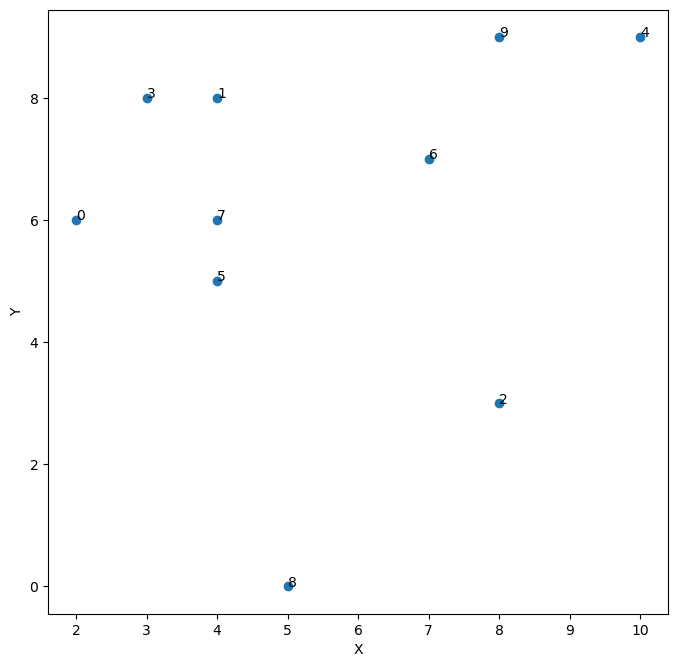

In [219]:
X = M[:, 0]
Y = M[:, 1]
from matplotlib.pyplot import figure
figure(figsize = (8,8), dpi = 100)
plt.scatter(X,Y)
plt.xlabel('X')
plt.ylabel('Y')
for i in range(N):
    plt.text(X[i], Y[i], str(i))

In [220]:
d_matrix = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i < j:
            d_matrix[i,j] = eu_distance(M[i], M[j])
        else:
            d_matrix[i,j] = 10**5

In [221]:
d_matrix_df = pd.DataFrame(d_matrix)
d_matrix_df.iloc[0:6, 0:6]

,0,1,2,3,4,5
0,100000.0,2.828427,6.708204,2.236068,8.544004,2.236068
1,100000.0,100000.000000,6.403124,1.000000,6.082763,3.000000
2,100000.0,100000.000000,100000.000000,7.071068,6.324555,4.472136
3,100000.0,100000.000000,100000.000000,100000.000000,7.071068,3.162278
4,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,7.211103
5,100000.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000


In [222]:
all_ds = np.unique(d_matrix) # all unique distances
len(all_ds)

27

In the distance matrix, we have 27 unique distances. However, if all node pairs have different distances, we should have 46 unique values:

In [223]:
((1+ (N-1))*(N-1))/2 + 1

46.0

In [224]:
# You can see that we have lots of pairs with the same distance:
for i in range(len(all_ds)):
    print(np.where(d_matrix == np.sort(all_ds)[i]))

(array([1, 5]), array([3, 7]))
(array([0, 1, 4]), array([7, 7, 9]))
(array([0, 0, 3, 6]), array([3, 5, 7, 9]))
(array([0]), array([1]))
(array([1]), array([5]))
(array([1, 3, 6]), array([6, 5, 7]))
(array([4, 5]), array([6, 6]))
(array([1, 2, 3]), array([9, 6, 6]))
(array([2]), array([8]))
(array([2]), array([5]))
(array([2, 7]), array([7, 9]))
(array([0, 3, 5]), array([6, 9, 8]))
(array([5]), array([9]))
(array([2]), array([9]))
(array([1, 7]), array([4, 8]))
(array([2]), array([4]))
(array([1]), array([2]))
(array([0, 0, 0, 4]), array([2, 8, 9, 7]))
(array([2, 3]), array([3, 4]))
(array([4]), array([5]))
(array([6]), array([8]))
(array([1]), array([8]))
(array([3]), array([8]))
(array([0]), array([4]))
(array([8]), array([9]))
(array([4]), array([8]))
(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6,
       6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]), array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3

For example, the distance between Node1 and Node3, and that between Node5 and Node7, is both 1. We need to design a tie-breaking rule. For example, we can stipulate that we group pair which contains the node with the smallest index. In the above example, we will group Node1 and Node3 first. 

In fact, this is the advantage of writing our own clustering algorithm instead of relying on existing packages such as `scikit learn` or `scipy`, which do not allow us to specify how to break ties. 

The challenge now is: how do we integrate this tie-breaking rule into our hierarchical clustering algorithm. 

In [225]:
import ast

def hierarchical_clustering_with_tie_breaking(M, d_matrix, target_cluster_num, method='single'):
    clusters = [[i] for i in range(len(M))]
    while len(clusters) > target_cluster_num:
        dmax = np.max(d_matrix) + 1
        dmin = dmax
        d_dict = {}
        min_cluster1 = None
        min_cluster2 = None
        for cluster1 in clusters:
            for cluster2 in clusters:
                if cluster1 != cluster2:
                    assert method in [
                        'single', 'complete', 'average'],\
                    'You have to choose from single, complete, and average'
                    if method == 'single':
                        d = single_linkage(cluster1, cluster2, d_matrix)
                    elif method == 'complete':
                        d = complete_linkage(cluster1, cluster2, d_matrix)
                    elif method == 'average':
                        d = average_linkage(cluster1, cluster2, d_matrix)
                        
                    if d < dmin:
                        dmin = d
                        min_cluster1 = cluster1
                        min_cluster2 = cluster2
        dist = np.array(list(d_dict.values()))
        dmin_idxs = np.where(dist == dmin)[0]
        cluster_pairs = list(d_dict.keys())
        if len(dmin_idxs) > 1:
            # cluster pairs with the same dmin
            cluster_pairs_with_dmin = [ast.literal_eval(cluster_pairs[i]) for i in dmin_idxs]
            flat_list = [item for sublist in cluster_pairs_with_dmin for item in sublist]
            min_idx = min(flat_list)
            for cluster_pair in cluster_pairs_with_dmin:
                if min_idx in cluster_pair:
                    cluster_pair_with_min_idx = cluster_pair
            min_cluster1 = cluster_pair_with_min_idx[0]
            min_cluster2 = cluster_pair_with_min_idx[1]
        clusters.remove(min_cluster1)
        clusters.remove(min_cluster2)
        clusters.append(min_cluster1 + min_cluster2)
    return clusters

In [226]:
clusters = hierarchical_clustering_with_tie_breaking(M, d_matrix, 3, method='complete')
clusters
# clustering result is the same as above.

[[1, 3, 0, 5, 7], [6, 4, 9], [2, 8]]